Subquestion 1: Which modes of transport have been affected most by the COVID-19 pandemic and how do these changes differ across transport modes?

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

# Plot the table as seen on CBR
csv_path = "/Users/bentedegen/Desktop/tilprogramming/groep24/Subquestion 1/Mobility_trend__per_stage__travel_modes_06102025_113641_1.csv"

df = pd.read_csv(csv_path, encoding="utf-8-sig")

df_clean = df.dropna()

display(df_clean.head(12))


,Sex,Age,Modes of travel,Travel motives,Periods,Stages per person per day (average) (number),Distance travelled per stage (average) (passenger kilometres),Average travel time per stage (Minutes)
0,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2014,0.82,12.21,21.99
1,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2015,0.79,12.23,21.87
2,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2016,0.79,12.15,21.95
3,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2017,0.80,12.23,22.15
4,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2018,0.82,12.17,21.89
5,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2019,0.77,12.04,21.81
6,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2020,0.55,10.97,20.55
7,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2021,0.54,11.43,21.21
8,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2022,0.62,11.79,21.82
9,Total male and female,18 to 24 years,Total,"Travel to/from work, (non)-daily commute",2023,0.66,11.93,22.23


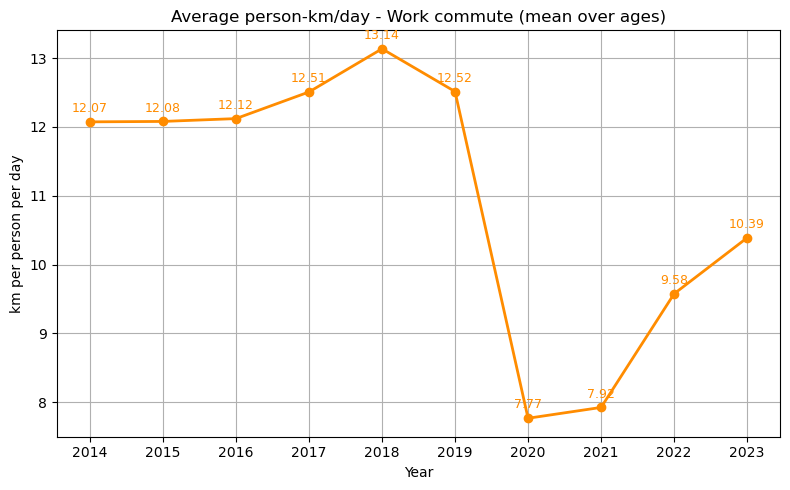

In [16]:
# Naming columns
stages_col = "Stages per person per day (average) (number)"
dist_col   = "Distance travelled per stage (average) (passenger kilometres)"

# Strings -> numeric
def to_num(s):
    return (s.astype(str)
             .str.replace("\u202f", "", regex=False)  # narrow no-break space
             .str.replace("\xa0",  "", regex=False)   # no-break space
             .str.replace(" ",     "", regex=False)
             .str.replace(",",     ".", regex=False)  # , -> .
             .pipe(pd.to_numeric, errors="coerce"))

df_clean[stages_col] = to_num(df_clean[stages_col])
df_clean[dist_col]   = to_num(df_clean[dist_col])


# Filter motive and totals
motive = "Travel to/from work, (non)-daily commute"
mask = (
    (df_clean["Travel motives"] == motive) &
    (df_clean["Sex"] == "Total male and female") &
    (df_clean["Modes of travel"] == "Total")
)
df_work = df_clean[mask].copy()

# Kilometers per day per person
df_work["person_km_per_day"] = df_work[stages_col] * df_work[dist_col]

# Average of all age groups per year 
df_avg = (
    df_work.groupby("Periods", as_index=False)["person_km_per_day"]
    .mean()
    .rename(columns={"person_km_per_day": "avg_person_km_per_day"})
)

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_avg["Periods"], df_avg["avg_person_km_per_day"],
         marker="o", color="darkorange", linewidth=2)

plt.title("Average person-km/day - Work commute (mean over ages)")
plt.xlabel("Year")
plt.ylabel("km per person per day")
plt.grid(True)
plt.xticks(df_avg["Periods"])

# Show exact value 
for x, y in zip(df_avg["Periods"], df_avg["avg_person_km_per_day"]):
    plt.text(x, y + 0.1, f"{y:.2f}", ha="center", va="bottom",
             fontsize=9, color="darkorange")

plt.tight_layout()
plt.show()


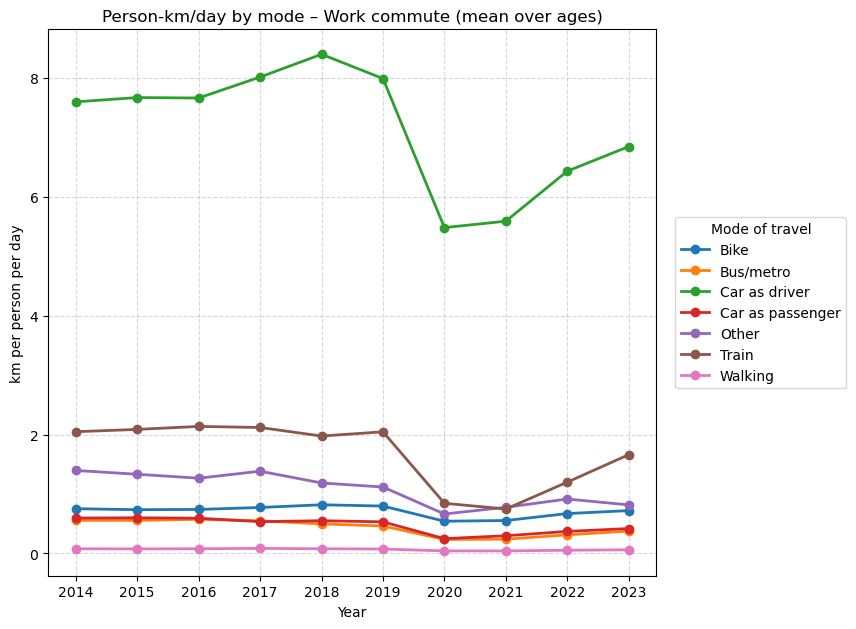

In [20]:
# Work-commute by transport mode over the years

# Filter for the desired travel motive and total gender category
# (we keep all transport modes except the overall 'Total' row)
motive = "Travel to/from work, (non)-daily commute"
df_modes = df_clean[
    (df_clean["Travel motives"] == motive) &
    (df_clean["Sex"] == "Total male and female")
].copy()

# Calculate total person-kilometres per day
df_modes["person_km_per_day"] = df_modes[stages_col] * df_modes[dist_col]

# Compute the average across all age groups per year and per transport mode
agg = (
    df_modes
    .groupby(["Periods", "Modes of travel"], as_index=False)["person_km_per_day"]
    .mean()
)

# Remove the 'Total' transport mode (we only want the individual modes)
agg = agg[agg["Modes of travel"] != "Total"].copy()

# Pivot the table: rows = years, columns = transport modes, values = avg km/person/day
pivot = (
    agg.pivot(index="Periods", columns="Modes of travel", values="person_km_per_day")
    .sort_index()
)

# Plot the trends over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot one line per transport mode
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", linewidth=2, label=col)

# Legend: positioned outside the plot area, aligned on the right
plt.legend(
    title="Mode of travel",
    bbox_to_anchor=(1.02, 0.5),  # position: slightly outside the right border
    loc="center left",           # align legend box to the left of the anchor
    ncol=1,                      # single column legend
    frameon=True
)

# Adjust layout to make space for the external legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Titles, labels, and style
plt.title("Person-km/day by mode – Work commute (mean over ages)")
plt.xlabel("Year")
plt.ylabel("km per person per day")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(pivot.index)  # ensure all years are shown on the x-axis

plt.show()

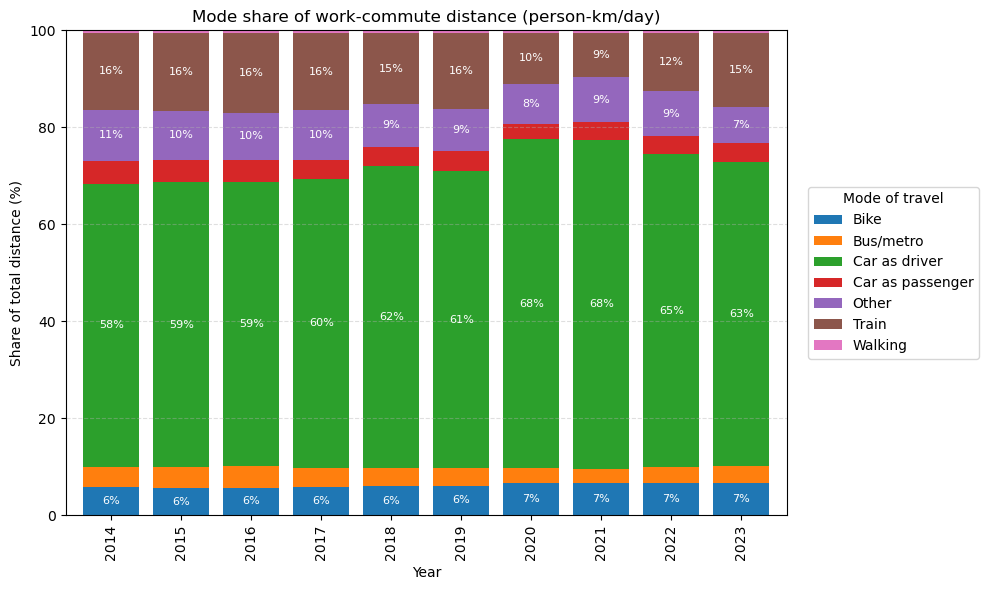

In [21]:
# 100% stacked bar: share per transport mode (work commute)
# Using 'pivot' from the previous cell (rows = years, columns = modes, values = km/person/day)

# Convert absolute values to yearly shares (percentages)
totals = pivot.sum(axis=1)
share = pivot.div(totals, axis=0) * 100  # convert to percentage of total per year

# Plot 100% stacked bars
ax = share.plot(kind="bar", stacked=True, figsize=(10, 6), width=0.8)

# Titles, labels, and style
ax.set_title("Mode share of work-commute distance (person-km/day)")
ax.set_xlabel("Year")
ax.set_ylabel("Share of total distance (%)")
ax.set_ylim(0, 100)
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

# Place legend outside the plot, aligned to the right
ax.legend(
    title="Mode of travel",
    bbox_to_anchor=(1.02, 0.5),  # position: slightly outside the right edge
    loc="center left",           # align legend box to the left of the anchor
    ncol=1,                      # single column
    frameon=True
)

# Add percentage labels on segments larger than 5%
for p in ax.patches:
    h = p.get_height()
    if h >= 5:  # only label segments that are visually large enough
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + h / 2
        ax.text(x, y, f"{h:.0f}%", ha="center", va="center", fontsize=8, color="white")

# Adjust layout to fit legend and axis labels nicely
plt.tight_layout()
plt.show()

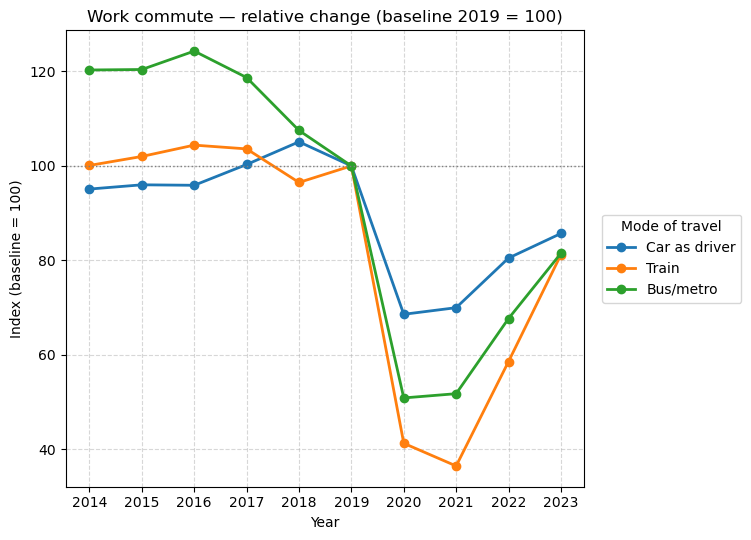

In [22]:
# Select only three relevant transport modes (robust to name differences)
# Some datasets use slightly different names  ("Passenger car (driver)" vs "Car as driver"),
# so we create a mapping that automatically matches whatever column names exist in the data.

wanted_modes = {
    "car as driver": ["Car as driver", "Passenger car (driver)"],
    "train": ["Train"],
    "bus/metro": ["Bus/metro", "Bus/tram/metro"],
}

# Map the modes names above to the actual column names present in 'pivot'
# which ensures the code works even if the dataset uses slightly different labels.
selected_cols = {}
for key, opts in wanted_modes.items():
    for name in opts:
        if name in pivot.columns:
            selected_cols[key] = name
            break  # stop once we find a matching column

# Create a smaller DataFrame with only the three selected transport modes
three = pivot[[selected_cols[k] for k in ["car as driver", "train", "bus/metro"]]].copy()
three.columns = ["Car as driver", "Train", "Bus/metro"]  # clean, consistent legend labels

# Calculate relative change per year (indexing to 2019 = 100)
# We normalize all values relative to the chosen baseline year (2019).
# That means 2019 = 100, and other years show how much higher/lower they are compared to that.
baseline_year = 2019 if 2019 in three.index else three.index.max()  # fallback if 2019 missing
indexed = (three / three.loc[baseline_year] * 100).round(1)

# Visualization
plt.figure(figsize=(9, 5.5))

# Plot one line per transport mode
for col in indexed.columns:
    plt.plot(indexed.index, indexed[col], marker="o", linewidth=2, label=col)

# Add a horizontal reference line at the baseline value (100)
plt.axhline(100, color="gray", linewidth=1, linestyle=":")

# Titles, labels, and formatting
plt.title(f"Work commute — relative change (baseline {baseline_year} = 100)")
plt.xlabel("Year")
plt.ylabel("Index (baseline = 100)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(indexed.index)

# Place the legend outside the plot, aligned to the right
plt.legend(title="Mode of travel", bbox_to_anchor=(1.02, 0.5), loc="center left")

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the final plot
plt.show()
